In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

# For reproducibility
np.random.seed(42)

# Sample sizes to test
sample_sizes = [20, 50, 100]

# Parameters for the two distributions
normal_params = {'mean': 80, 'std': 20}
hyper_params = {'mean': 220, 'std': 50}

# Step 1: Create datasets outside the loop
datasets = {}  # Dictionary to store datasets keyed by sample size

for n in sample_sizes:
    normal_data = np.random.normal(loc=normal_params['mean'], scale=normal_params['std'], size=n//2)
    hyper_data = np.random.normal(loc=hyper_params['mean'], scale=hyper_params['std'], size=n//2)
    glucose_values = np.concatenate([normal_data, hyper_data]).reshape(-1, 1)
    datasets[n] = glucose_values  # Store for later use


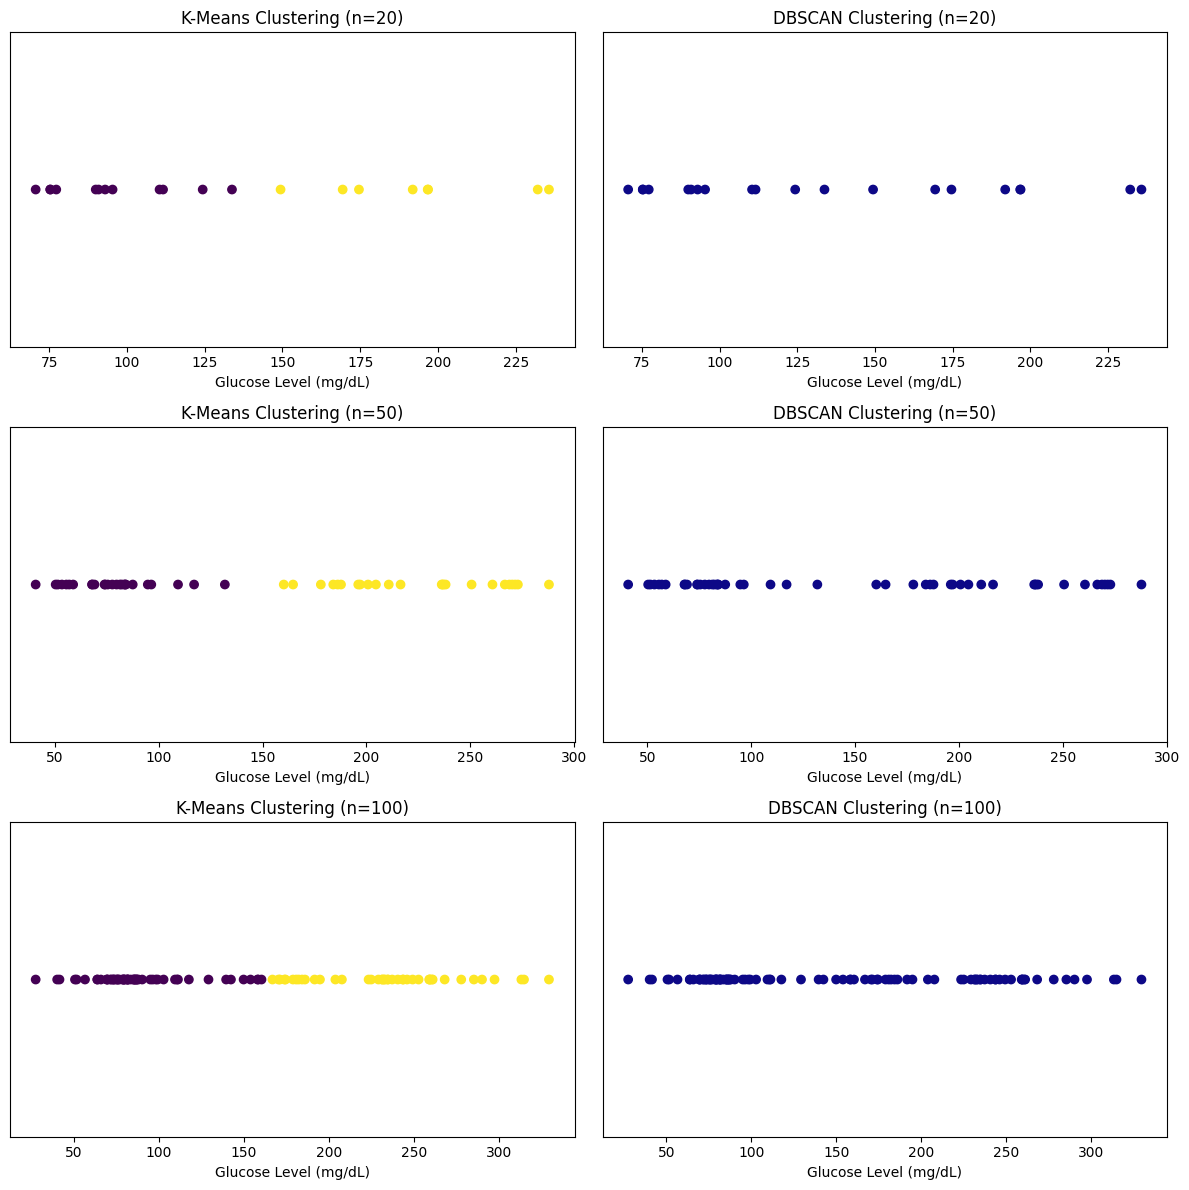

In [3]:
# Step 2: Plotting and clustering
fig, axes = plt.subplots(len(sample_sizes), 2, figsize=(12, 12))

for i, n in enumerate(sample_sizes):
    glucose_values = datasets[n]

    # Standardize for DBSCAN
    scaler = StandardScaler()
    glucose_scaled = scaler.fit_transform(glucose_values)

    # K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans_labels = kmeans.fit_predict(glucose_values)

    axes[i, 0].scatter(glucose_values, np.zeros_like(glucose_values), c=kmeans_labels, cmap='viridis')
    axes[i, 0].set_title(f'K-Means Clustering (n={n})')
    axes[i, 0].set_xlabel('Glucose Level (mg/dL)')
    axes[i, 0].set_yticks([])

    # DBSCAN clustering
    dbscan = DBSCAN(eps=0.8, min_samples=2)  # eps chosen heuristically for 1D
    dbscan_labels = dbscan.fit_predict(glucose_scaled)

    axes[i, 1].scatter(glucose_values, np.zeros_like(glucose_values), c=dbscan_labels, cmap='plasma')
    axes[i, 1].set_title(f'DBSCAN Clustering (n={n})')
    axes[i, 1].set_xlabel('Glucose Level (mg/dL)')
    axes[i, 1].set_yticks([])

plt.tight_layout()
plt.show()

In [28]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve

# 1. Initialize parameters
def initialize_params(X):
    means = np.random.choice(X, 2, replace=False)
    variances = [np.var(X)] * 2
    weights = [0.5, 0.5]
    return np.array(means), np.array(variances), np.array(weights)

# 2. E-step
def expectation_step(X, means, variances, weights):
    n = len(X)
    responsibilities = np.zeros((n, 2))
    for k in range(2):
        responsibilities[:, k] = weights[k] * norm.pdf(X, means[k], np.sqrt(variances[k]))
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# 3. M-step
def maximization_step(X, responsibilities):
    Nk = responsibilities.sum(axis=0)
    means = (responsibilities * X[:, np.newaxis]).sum(axis=0) / Nk
    variances = ((responsibilities * (X[:, np.newaxis] - means) ** 2).sum(axis=0)) / Nk
    weights = Nk / len(X)
    return means, variances, weights

# 4. Threshold computation
def find_intersection(mu1, sigma1, w1, mu2, sigma2, w2):
    def equation(x):
        return w1 * norm.pdf(x, mu1, sigma1) - w2 * norm.pdf(x, mu2, sigma2)
    x0 = (mu1 + mu2) / 2
    return fsolve(equation, x0)[0]

# 5. EM Loop with threshold delta tolerance
def run_gmm(X, max_iters=100, tol=1e-6):
    means, variances, weights = initialize_params(X)
    prev_threshold = None

    for _ in range(max_iters):
        responsibilities = expectation_step(X, means, variances, weights)
        means, variances, weights = maximization_step(X, responsibilities)

        # Find current threshold
        mu1, mu2 = means
        sigma1, sigma2 = np.sqrt(variances)
        w1, w2 = weights
        threshold = find_intersection(mu1, sigma1, w1, mu2, sigma2, w2)

        # Convergence check based on threshold
        if prev_threshold is not None and abs(threshold - prev_threshold) < tol:
            break
        prev_threshold = threshold

    return means, variances, weights, responsibilities, threshold

# 6. Final label assignment
def assign_labels(responsibilities):
    return np.argmax(responsibilities, axis=1)


In [54]:
# Sample 1D data
X = datasets[100].flatten()


In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_gmm_results(X, labels, means, variances, weights, threshold):
    colors = ['tab:blue', 'tab:orange']
    x_range = np.linspace(min(X) - 1, max(X) + 1, 500)

    # Plot data points with labels
    for k in range(2):
        plt.scatter(X[labels == k], [0.02] * np.sum(labels == k), 
                    color=colors[k], label=f'Component {k}', alpha=0.6)

    # Plot Gaussians
    for k in range(2):
        pdf = weights[k] * norm.pdf(x_range, means[k], np.sqrt(variances[k]))
        plt.plot(x_range, pdf, color=colors[k], linestyle='-', lw=2, label=f'Gaussian {k}')

    # Plot threshold
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')

    plt.title('GMM Results with Labels and Threshold')
    plt.xlabel('X')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


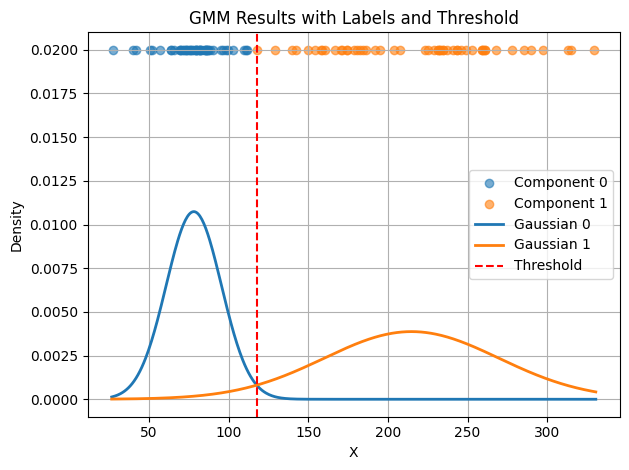

In [56]:
means, variances, weights, responsibilities, threshold = run_gmm(X)
labels = assign_labels(responsibilities)
plot_gmm_results(X, labels, means, variances, weights, threshold)